# Session 8: Coding Solution

## Classic filter types

- The Deep Convolutional Neural Network model essentially learns filters to be able to extract features in the data set (the numbers in the filter are the weights to learn)
- The concept of filter and convolution has been around for a long time, filters at that time were hand-crafted and each filter only had 1 effect.
- The following section will go through the 2 most basic filters, which are vertical and horizontal edge detection.

**Download sample image**

In [ ]:
!wget https://i.imgur.com/kbWNDCh.png

--2023-07-21 17:49:23--  https://i.imgur.com/kbWNDCh.png
Resolving i.imgur.com (i.imgur.com)... 151.101.24.193
Connecting to i.imgur.com (i.imgur.com)|151.101.24.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480377 (469K) [image/png]
Saving to: ‘kbWNDCh.png’

kbWNDCh.png         100%[===================>] 469.12K  1.02MB/s    in 0.4s    

2023-07-21 17:49:24 (1.02 MB/s) - ‘kbWNDCh.png’ saved [480377/480377]



**Read the image**

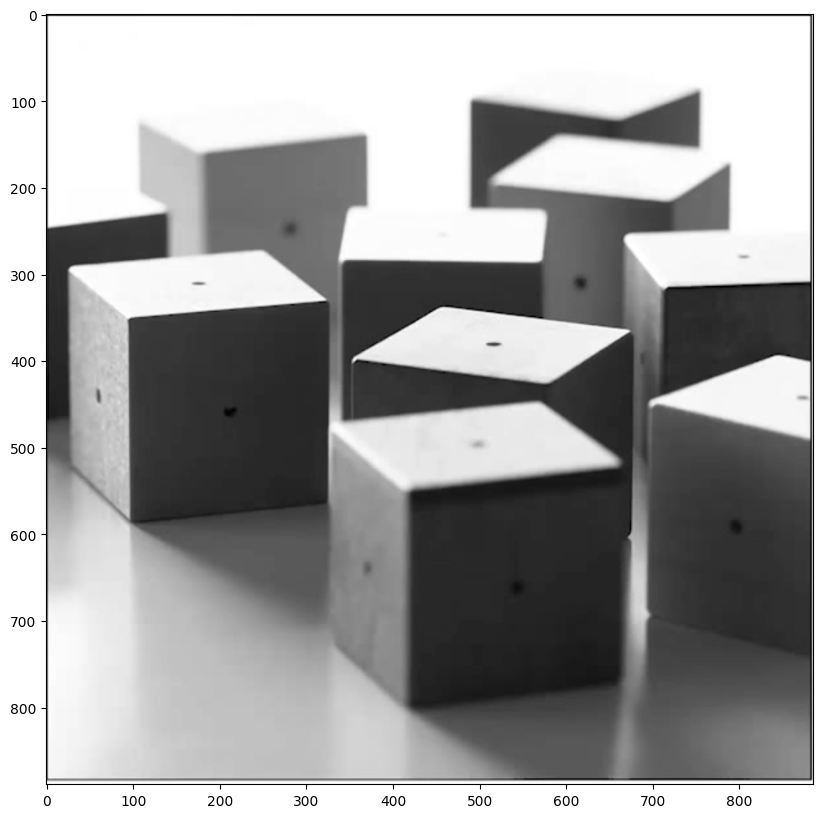

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# read the image with Pillow
img = Image.open('kbWNDCh.png').convert('L')

# convert into numpy array
img = np.array(img)

# show the image
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')  # imshow function receive an numpy array
plt.show()

**Create a filter**

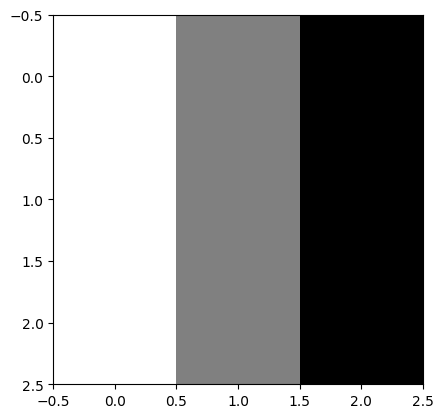

In [ ]:
filter_vertical = np.array([
  [10, 0, -10],
  [10, 0, -10],
  [10, 0, -10]
])

plt.imshow(filter_vertical, cmap='gray')
plt.show()

Looking at the newly created filter, we see that the brightness of the filter changes horizontally $\rightarrow$ filter capable of detecting vertical strokes

Perform convolution operation with ``padding='same'``

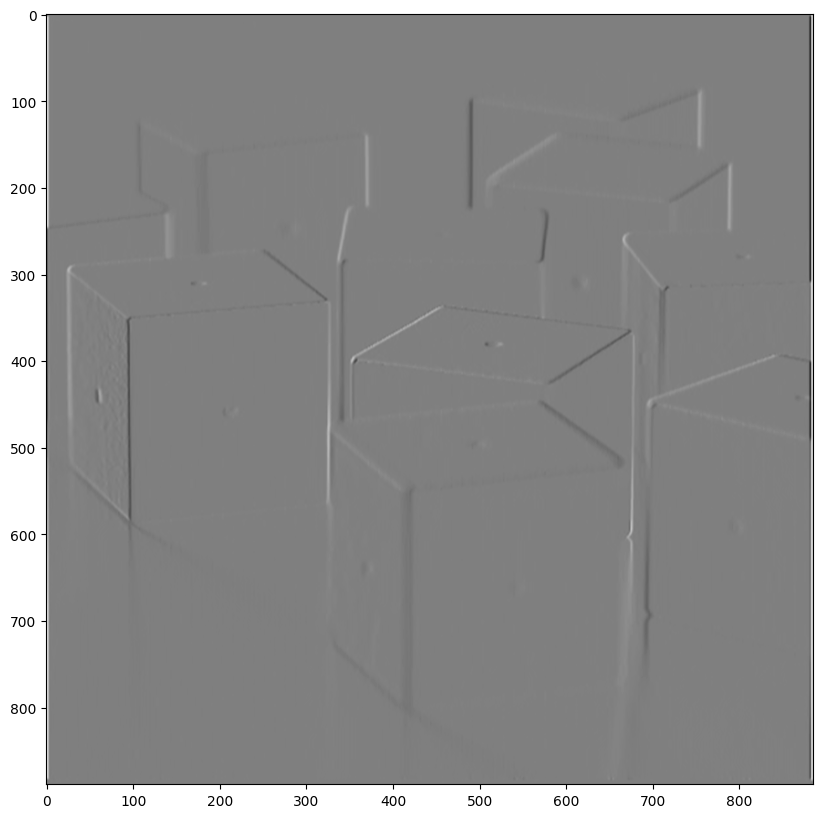

In [ ]:
from scipy.signal import convolve

res_vertical = convolve(img, filter_vertical, mode='same', method='direct')
plt.figure(figsize=(10,10))
plt.imshow(res_vertical, cmap='gray')
plt.show()

Observing the results we see that:
- At vertical edges, the results are easy to see
- At oblique edges, we get faint results
- On horizontal edges, the result is very blurry or none at all

We continue to experiment with horizontal edge detection filters

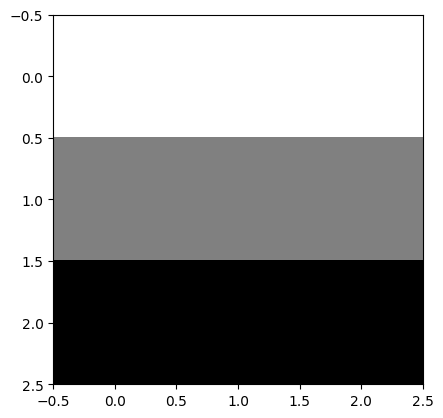

In [ ]:
filter_horizontal = np.array([
  [10, 10, 10],
  [0, 0, 0],
  [-10, -10, -10]
])

plt.imshow(filter_horizontal, cmap='gray')
plt.show()

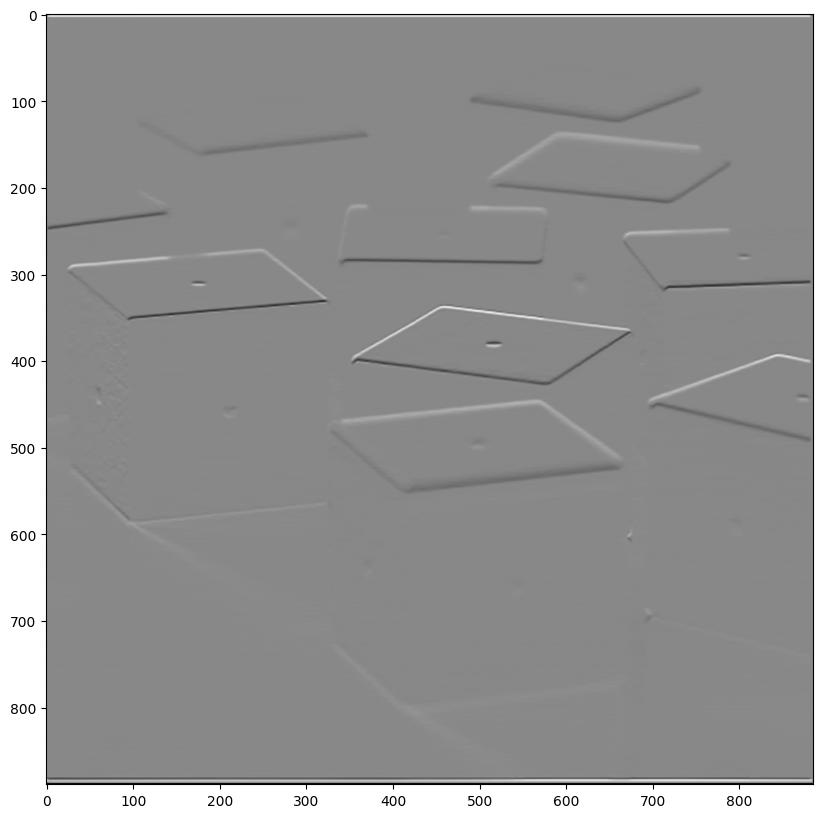

In [ ]:
res_horizontal = convolve(img, filter_horizontal, mode='same', method='direct')

plt.figure(figsize=(10,10))
plt.imshow(res_horizontal, cmap='gray')
plt.show()

So how to detect horizontal and vertical edges at the same time?

Let's just add up the above 2 results

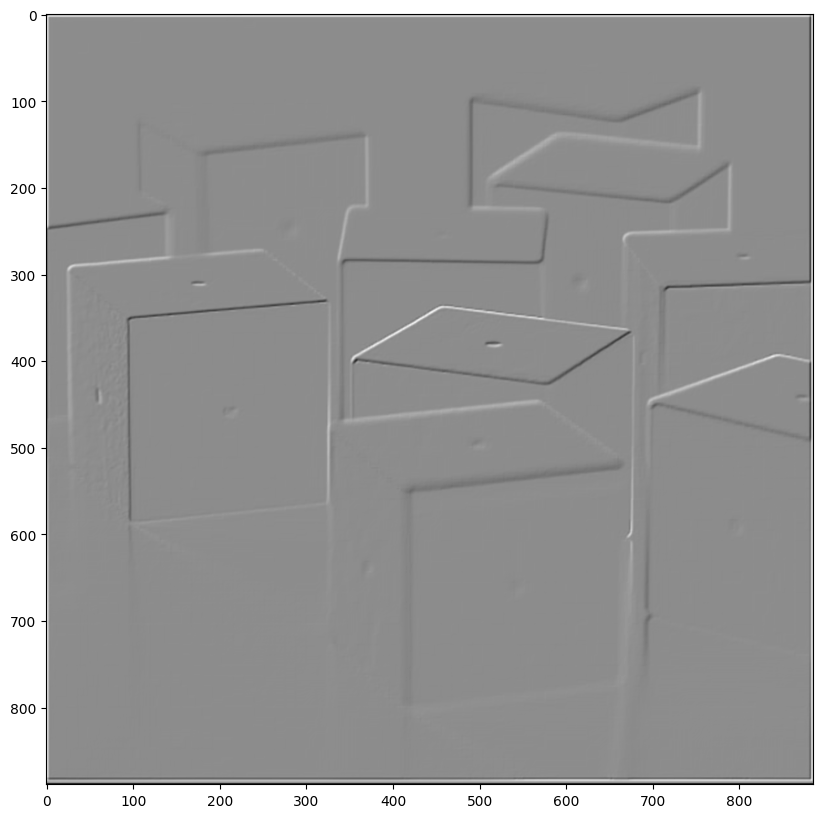

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(res_vertical + res_horizontal, cmap='gray')
plt.show()

There are many other types of filters, you can refer to in the lecture slide or Google, then apply it to the above lesson.

# The problem of recognizing diseases for cowpea leaves

In this Assignment, we will use CNN to classify whether the leaves of beans belong to be sick or not.
- Normal leaves
- Angular Leaf spot
- Bean Rust

We will load the available dataset of Tensorflow

## Prepare the dataset

**Download data**

In [ ]:
import tensorflow_datasets as tfds

(train, val, test), info = tfds.load('beans',
                                      split=['train', 'validation', 'test'],
                                      shuffle_files=True,
                                      as_supervised=True,
                                      with_info=True)

**View dataset description**

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path=PosixGPath('/tmp/tmp4w78aos7tfds'),
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInfo

**Check out the images**

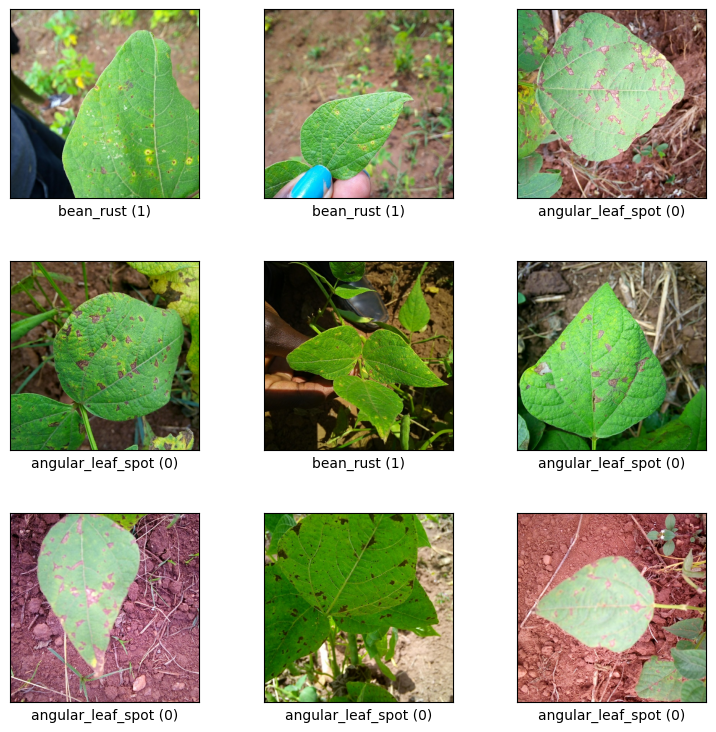

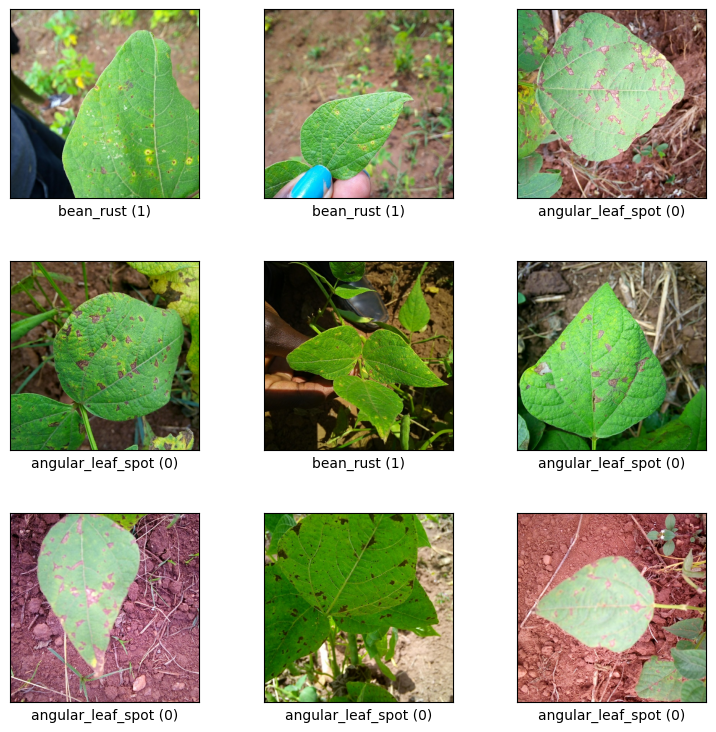

In [ ]:
tfds.show_examples(train, info)

To make it easier to code, we will convert all data to numpy array

In [ ]:
import numpy as np

In [ ]:
train_label = []
train_image = []

for image, label in tfds.as_numpy(train):
  train_image.append(image)
  train_label.append(label)

train_image = np.array(train_image)
train_label = np.array(train_label)

print("Train Set")
print("Shape:", train_image.shape, train_label.shape)
print("Label distribution:", np.unique(train_label, return_counts=True))

Train Set
Shape: (1034, 500, 500, 3) (1034,)
Label distribution: (array([0, 1, 2]), array([345, 348, 341]))


In [ ]:
val_label = []
val_image = []

for image, label in tfds.as_numpy(val):
  val_image.append(image)
  val_label.append(label)

val_image = np.array(val_image)
val_label = np.array(val_label)

print("Validation Set")
print("Shape:", val_image.shape, val_label.shape)
print("Label distribution:", np.unique(val_label, return_counts=True))

Validation Set
Shape: (133, 500, 500, 3) (133,)
Label distribution: (array([0, 1, 2]), array([44, 45, 44]))


In [ ]:
test_label = []
test_image = []
for image, label in tfds.as_numpy(test):
  test_image.append(image)
  test_label.append(label)
test_image = np.array(test_image)
test_label = np.array(test_label)
print("Test Set")
print("Shape:", test_image.shape, test_label.shape)
print("Label distribution:", np.unique(test_label, return_counts=True))

Test Set
Shape: (128, 500, 500, 3) (128,)
Label distribution: (array([0, 1, 2]), array([43, 43, 42]))


In [ ]:
# Remove unnecessary variables
del train, val, test

## Image Augmentation

With visual-style data, data generation is quite simple, 1 few examples
- Pixel shifting
- Rotation
- Flip
- Zoom-in/out
- Change color


Generating more data gives the model the ability to generalize better when used in practice. At the same time, when we have a lot of data, we also partly reduce overfitting.

There are 2 ways to augment data:
- Offline: augment first, save images and then train
- Online: augmented during training (before putting images into the model)

The commonly used Online Augmentation technique is called Random Augmentation, for example:
- Create a pipeline consisting of 4 augmented steps as above, each step is assigned 1 probability: do or do not do, the input of step `n` is the result of step `n-1`
- In each step: Create 1 range of random values to perform Augment (how many pixels to shift, how many degrees to rotate, how much zoom-in/out)
- The input image will be fed through the above pipeline → the probability that image A in epoch 2 will be augmented like image A in epoch 1 is very unlikely -> the model is almost trained with an infinite number of images.

`tensorflow.keras` supports Online Augmentation with layers (note, in `tf.keras` each layer we have no control over the probability of execution / non-execution), the pipeline is built using the `Sequential` API. Supported layers include:
- `RandomBrightness`
- `RandomContrast`
- `RandomCrop`
- `RandomFlip`
- `RandomHeight`
- `RandomRotation`
- `RandomTranslation`
- `RandomWidth`
- `RandomZoom`

You can read all the parameters of the above layers [at this document](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomBrightness)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomBrightness, RandomContrast, RandomCrop, RandomHeight, RandomTranslation, RandomWidth, RandomZoom

In [ ]:
# Simple Augment Pipeline example consists of 2 flip and rotate steps
# Instead of augmentor.add(layer), we put the layer at initialization

augmentor = Sequential([
  Input(shape=(500,500,3)),
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2), # Read the document to understand the meaning behind 0.2
])

(1, 500, 500, 3)


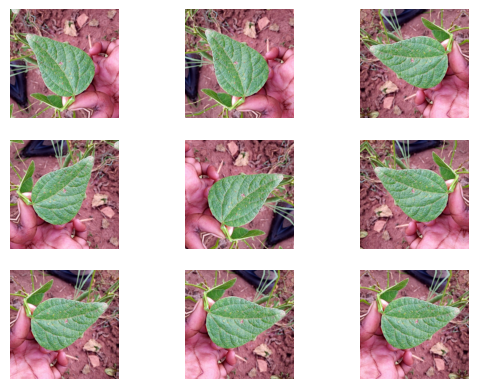

In [ ]:
import matplotlib.pyplot as plt

image = train_image[0]
image = np.expand_dims(image, axis=0)  # add the batch dimension
print(image.shape)

'''
Put images into the Augmentor 9 times -> can produce 9 different images
  - Augment and convert the data type back to numpy
  - Augment only occurs when calling Augmentor(image) or when train using the fit function
  - Delete the first dimension (batch size) to plot with matplotlib with squeeze()
  - After augmentation is complete, there will be a dtype of float
  - We haven't normalized the image yet, so pyplot doesn't understand the 0-255 float data as an image
  - Convert back to int
'''

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = augmentor(image).numpy()
  augmented_image = augmented_image.squeeze()
  augmented_image = augmented_image.astype(int)
  plt.imshow(augmented_image)
  plt.axis("off")

**Try other augmentation techniques**

In [ ]:
augmentor = Sequential([
    Input(shape=(500,500,3)),
    RandomBrightness(0.2),
    RandomContrast(0.2),
    RandomCrop(int(0.8 * 500), int(0.8 * 500)),
    RandomFlip("horizontal_and_vertical"),
    RandomHeight(0.2),
    RandomRotation(0.2),
    RandomTranslation(0.1, 0.1),
    RandomWidth(0.2),
])

(1, 500, 500, 3)


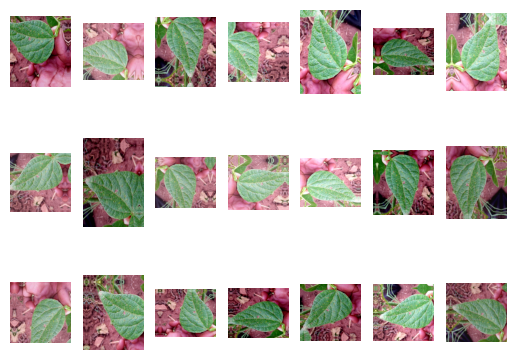

In [ ]:
import matplotlib.pyplot as plt
image = train_image[0]
image = np.expand_dims(image, axis = 0)
print(image.shape)

for i in range(21):
  ax = plt.subplot(3, 7, i + 1)
  augmented_image = augmentor(image).numpy()
  augmented_image = augmented_image.squeeze()
  augmented_image = augmented_image.astype(int)
  plt.imshow(augmented_image)
  plt.axis("off")

**Predict**

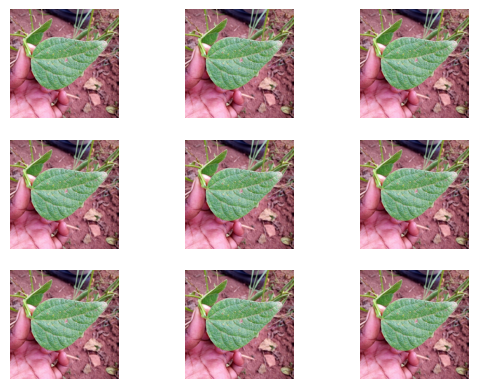

In [ ]:
import matplotlib.pyplot as plt
image = train_image[0]
image = np.expand_dims(image, axis=0)

# Augmentation will not take place when calling predict (inference)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  # Predict function returs Numpy Array
  augmented_image = augmentor.predict(image, verbose=0) # verbose = 0 -> no progress bar
  augmented_image = augmented_image.squeeze()
  augmented_image = augmented_image.astype(int)
  plt.imshow(augmented_image)
  plt.axis("off")

## Rescaling

Normally, we will normalize the image by dividing 255 and the image data type will now be `float` instead of `int`, saving the `float` will take more RAM than `int` and this data set is relatively large (image 500x500 pixels) so we will not normalize first but will integrate this normalize step into the model
- The first layer in the model is `Input`
- The next layer is [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling`)


Usage example
```python
from tensorflow.keras.layers import Rescaling, Input

model = Sequential()
model.add(Input(shape=(3, 3, 3)))
model.add(Rescaling(scale=1./255))
# ... next layers
```



In [ ]:
from tensorflow.keras.layers import Rescaling, Input

model = Sequential()
model.add(Input(shape=(3, 3, 3)))
model.add(Rescaling(scale = 1./255))

In [ ]:
# run to see the results
t = np.ones(shape=(1,3,3,3)) * 255
print(t)
t = model.predict(t)
print(t)

[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]]]
1/1 [==============================] - 0s 41ms/step
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]


## Global Average Pooling

In the theory Lab, we see that CNNs final feature map will be `Flatten` before passing to the `Dense` layer

The fact that `Flatten` has 1 drawback is that if the final feature map is large, we will have a lot of weight in the `Dense` layer → FLOPs are high → train long.

A more common practice is that instead of using `Flatten` we will use the layer `GlobalAveragePooling2D`

This layer will average each feature map → if in the last Convolution layer we have 512 feature maps, the result of `GlobalAveragePooling2D` will be a 512-dimensional vector → reduce FLOPs and a lot of weight in the `Dense` layer

```python
model = Sequential()
# ...
# replace layer Flatten()
model.add(GlobalAveragePooling2D())
model.add(Dense(...))
```

## Build the architecture of model and start training

#### TODO: READ CAREFULLY BEFORE CODING
- Build the Augmentation Pipeline of your own
- Build CNN model (layer `Rescaling` is required)
  - Recode the models yourself in the Lab
  - Because the input image is quite large, you may have to use multiple `Convolution-Batchnorm-Relu` blocks instead of just 3.
  - The architecture of VGG-16 is very easy to understand. Try searching Google and implementing this architecture (reduce the number of layers, there is no need for 16 layers because the train takes a long time)
  - You need to use `SeparableConv2D` instead of `Conv2D` and `GlobalAveragePooling2D` instead of `Flatten` to reduce FLOPs and the number of weights to be able to train using Colab.
- Connect Augmentation Pipeline and CNN with another `Sequential` (Because when inference, the augmentation pipeline will be disabled, so we can completely use it in real application)
- Train the model, and make predictions on the Test set(Confusion Matrix, Classification Report)
  - If encountering error `Out of Memory`, you should reduce the number of `batch_size` when training
- Draw some pictures to see the predicted results of the model.
- The training may be a bit long, you can make tea or coffee to enjoy while looking at the train screen.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, Rescaling, Dense, SeparableConv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

# one-hot encoding
train_label = to_categorical(train_label, 3)
val_label = to_categorical(val_label, 3)
test_label = to_categorical(test_label, 3)

In [ ]:
# augmentation
augmentor = Sequential([
    Input(shape=(500, 500, 3)),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2)
])

In [ ]:
# cnn model
cnn = Sequential([
    Input(shape=(500, 500, 3)),
    Rescaling(scale=1./255),
    SeparableConv2D(32, 3, padding="same"),
    SeparableConv2D(32, 3, padding="same"),
    MaxPooling2D(),
    SeparableConv2D(64, 3, padding="same"),
    SeparableConv2D(64, 3, padding="same"),
    MaxPooling2D(),
    SeparableConv2D(128, 3, padding="same"),
    SeparableConv2D(128, 3, padding="same"),
    MaxPooling2D(),
    SeparableConv2D(256, 3, padding="same"),
    SeparableConv2D(256, 3, padding="same"),
    MaxPooling2D(),
    SeparableConv2D(512, 3, padding="same"),
    SeparableConv2D(512, 3, padding="same"),
    MaxPooling2D(),
    GlobalAveragePooling2D(),
    Dense(3, activation="softmax"),
])

model = Sequential([
    Input(shape=(500, 500,3)),
    augmentor,
    cnn
])

In [ ]:
cnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 500, 500, 3)       0         
                                                                 
 separable_conv2d_20 (Separa  (None, 500, 500, 32)     155       
 bleConv2D)                                                      
                                                                 
 separable_conv2d_21 (Separa  (None, 500, 500, 32)     1344      
 bleConv2D)                                                      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 250, 250, 32)     0         
 g2D)                                                            
                                                                 
 separable_conv2d_22 (Separa  (None, 250, 250, 64)     2400      
 bleConv2D)                                          

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 500, 500, 3)       0         
                                                                 
 sequential_11 (Sequential)  (None, 3)                 540158    
                                                                 
Total params: 540,158
Trainable params: 540,158
Non-trainable params: 0
_________________________________________________________________


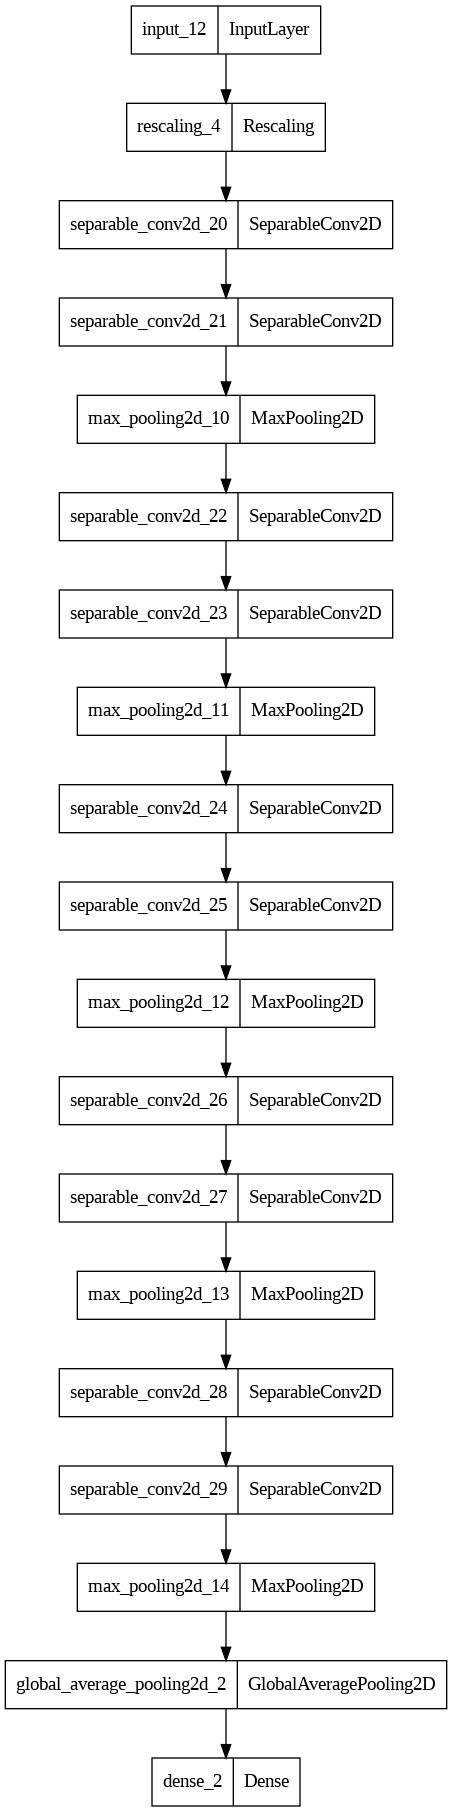

In [ ]:
tf.keras.utils.plot_model(cnn)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_image, train_label, batch_size=8, epochs=10)
predictions = model.predict(test_image)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


pred_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_label, pred_labels)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show()

In [ ]:
print(classification_report(test_label, pred_labels))